# Beyond Visible Spectrum: AI for Agriculture 2026
> Beyond the limit

## Overview

Solve problems: 'Wheat Disease Recognition', use 3 type of images: 
- RGB: normal picture (3 kernels)
- MS: multispectral image (5 kernels)
- HS: hyperspectral image (128 kernels), after processing: ~101 kernels

In [25]:
import os, re, random
from dataclasses import dataclass
from typing import Dict, Optional, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tifffile as tiff # read file tif (HS)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm # pretrained model

## Configuration

- HS has 125 bands, but after removing noisy bands (first: 10, last: 14), we use 101 bands.
- Resize all images to 224x224

In [26]:
@dataclass
class CFG:
    # root directory and train, validation dir
    ROOT: str = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026/Kaggle_Prepared"  
    TRAIN_DIR: str = "train"
    VAL_DIR: str = "val"

    # flag for each image type
    USE_RGB: bool = False # only use HS
    USE_MS: bool  = False # only use HS
    USE_HS: bool  = True

    # image size for all
    IMG_SIZE: int = 224     # resize all image: 224x224

    # trainning hyperparameters
    BATCH_SIZE: int = 32  
    EPOCHS: int = 15
    LR: float = 3e-4        # 0.0003: learning rate
    WD: float = 1e-4        # 0.0001: weight decay or Norm2(L2) regularization

    NUM_WORKERS: int = 4    # number of workers for dataloader
    SEED: int = 1111        # constant seed number --> 1111

    RGB_BACKBONE: str = "convnext_base"  # backbone RGB, ConvNeXt, ImageNet
    AMP: bool = True        # automatic mixed precision (training faster)

    HS_DROP_FIRST: int = 10 # number of head bands -> drop
    HS_DROP_LAST: int = 14  # number of tail bands -> drop

    # save the result
    OUT_DIR: str = "/kaggle/working/"
    BEST_CKPT: str = "best.pt"

# label mapping
LABELS = ["Health", "Rust", "Other"]
LBL2ID = {k: i for i, k in enumerate(LABELS)} # Health -> 0, Rust -> 1, Other -> 2
ID2LBL = {i: k for k, i in LBL2ID.items()} 

## Data processing

- Indexing: 
```
{
    "Health_hyper_1": {
        "rgb": "train/RGB/Health_hyper_1.png",
        "ms":  "train/MS/Health_hyper_1.tif",
        "hs":  "train/HS/Health_hyper_1.tif"
    },
    "Rust_hyper_5": {
        "rgb": "train/RGB/Rust_hyper_5.png",
        "ms":  "train/MS/Rust_hyper_5.tif",
        "hs":  "train/HS/Rust_hyper_5.tif"
    }
}
```
- Create DataFrame: 
```
[base_id, label, rgb, ms, hs]
[
    [Health_hyper_1, Health, Health_hyper_1.png, Health_hyper_1.tif, Health_hyper_1.tif],
    [Rust_hyper_5, Rust, Rust_hyper_5.png, Rust_hyper_5.tif, Rust_hyper_5.tif]
]
```

- Stratified holdout: 
    - Train: 90%
    - Validation: 10%

In [27]:
# for reproducible result
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# get path of all file,sort
def list_files(folder: str, exts: Tuple[str, ...]) -> List[str]:
    if not os.path.isdir(folder):
        return []
    out = []
    for fn in os.listdir(folder):
        if fn.lower().endswith(exts):
            out.append(os.path.join(folder, fn))
    return sorted(out)

# get basename 
def base_id(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]
# extract label from basename
def parse_label_from_train_name(bid: str) -> Optional[str]:
    m = re.match(r"^(Health|Rust|Other)_", bid)
    return m.group(1) if m else None

# indexing
def build_index(root: str, split: str) -> Dict[str, Dict[str, str]]:
    split_dir = os.path.join(root, split)
    rgb_dir = os.path.join(split_dir, "RGB")
    ms_dir  = os.path.join(split_dir, "MS")
    hs_dir  = os.path.join(split_dir, "HS")

    rgb_files = list_files(rgb_dir, (".png", ".jpg", ".jpeg"))
    ms_files  = list_files(ms_dir, (".tif", ".tiff"))
    hs_files  = list_files(hs_dir, (".tif", ".tiff"))

    idx: Dict[str, Dict[str, str]] = {}
    for p in rgb_files:
        idx.setdefault(base_id(p), {})["rgb"] = p
    for p in ms_files:
        idx.setdefault(base_id(p), {})["ms"] = p
    for p in hs_files:
        idx.setdefault(base_id(p), {})["hs"] = p
    return idx
# create data frame for training and validation
def make_train_df(train_idx: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    rows = []
    for bid, paths in train_idx.items():
        lab = parse_label_from_train_name(bid)
        if lab is None:
            continue
        rows.append({
            "base_id": bid,
            "label": lab,
            "rgb": paths.get("rgb"),
            "ms":  paths.get("ms"),
            "hs":  paths.get("hs"),
        })
    return pd.DataFrame(rows)

def make_val_df(val_idx: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    rows = []
    for bid, paths in val_idx.items():
        rows.append({
            "base_id": bid,
            "rgb": paths.get("rgb"),
            "ms":  paths.get("ms"),
            "hs":  paths.get("hs"),
        })
    return pd.DataFrame(rows)

# split train set to train & validation --> balance class
def stratified_holdout(df: pd.DataFrame, frac: float = 0.1, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    parts = []
    for lab, g in df.groupby("label"):
        n = max(1, int(len(g) * frac))
        parts.append(g.iloc[:n])
    df_va = pd.concat(parts).drop_duplicates("base_id")
    df_tr = df[~df["base_id"].isin(df_va["base_id"])].reset_index(drop=True)
    df_va = df_va.reset_index(drop=True)
    return df_tr, df_va

## Read data and pre-processing images

- Read image: 
1. RGB: original (H, W, 3) unit8 [0-255]
    - -> BGR to RGB
    - -> normalize to [0-1]
    - -> Permute: (3, H, W)
    - -> ImageNet normalization

-> Output: Tensor (3, H, W) or (3, 224, 224), float32

2. MS: original (H, W, 5) unit8 [0-255]
    - -> normalize to [0-1]
    - -> Permute: (5, H, W)

3. HS: original (H, W, 125) unit16 [0-65535]
    - -> Remove noisy bands (first 10, last 14) -> (H, W, 101)
    - -> normalize to [0-1]
    - -> Permute: (101, H, W)

- Resize: 224x224 for all images
- Padding/Cropping: ensure all HS images have 101 bands

- Data augmentation: RandomHorizontalFlip, RandomVerticalFlip, RandomRotation(90)

In [28]:
# normalization constants: ImageNet 
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # (C, H, W) for broadcasting
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def fix_channels(x: torch.Tensor, target_c: int) -> torch.Tensor:
    # x: (C,H,W) -> (target_c,H,W) by crop or zero-pad
    c, h, w = x.shape
    if c == target_c:
        return x
    if c > target_c:
        return x[:target_c]
    pad = torch.zeros((target_c - c, h, w), dtype=x.dtype)
    return torch.cat([x, pad], dim=0)
    
def read_rgb(path: str) -> torch.Tensor:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    x = torch.from_numpy(img).permute(2, 0, 1)  # numpy to torch tensor and (H, W, C) -> (C, H, W) = (3,H,W)
    x = (x - IMAGENET_MEAN) / IMAGENET_STD      # ImageNet normalization 
    return x

def read_tiff_multiband(path: str) -> np.ndarray:
    arr = tiff.imread(path)  # (H,W,C) or (C,H,W)
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D TIFF, got {arr.shape} for {path}")
    if arr.shape[0] < arr.shape[1] and arr.shape[0] < arr.shape[2]:
        arr = np.transpose(arr, (1, 2, 0))  # -> (H,W,C)
    return arr

def normalize_per_band_minmax(x: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    H, W, C = x.shape
    flat = x.reshape(-1, C) # (H*W, C)
    mn = flat.min(axis=0)
    mx = flat.max(axis=0)
    denom = (mx - mn)
    denom[denom < eps] = 1.0
    x = (x - mn.reshape(1, 1, C)) / denom.reshape(1, 1, C)
    return np.clip(x, 0.0, 1.0)

def read_ms(path: str) -> torch.Tensor:
    arr = read_tiff_multiband(path)           # (H,W,5)
    arr = normalize_per_band_minmax(arr)
    return torch.from_numpy(arr).permute(2, 0, 1)  # (5,H,W)

def read_hs(path: str, drop_first: int, drop_last: int) -> torch.Tensor:
    arr = read_tiff_multiband(path)           # (H,W,B)
    B = arr.shape[2]
    if B > (drop_first + drop_last + 1):
        arr = arr[:, :, drop_first:B - drop_last]
    arr = normalize_per_band_minmax(arr)
    return torch.from_numpy(arr).permute(2, 0, 1)  # (B',H,W)

def resize_tensor(x: torch.Tensor, size: int) -> torch.Tensor:
    # x: (C,H,W) -> (C,size,size)
    return F.interpolate(x.unsqueeze(0), size=(size, size), mode="bilinear", align_corners=False).squeeze(0)

# augmentation : apply to all modalities
def apply_joint_aug(x_rgb, x_ms, x_hs):
    k = random.randint(0, 3)
    do_h = random.random() < 0.5
    do_v = random.random() < 0.5

    def _tf(x):
        if x is None:
            return None
        if k:
            x = torch.rot90(x, k, dims=(1, 2))
        if do_h:
            x = torch.flip(x, dims=(2,))
        if do_v:
            x = torch.flip(x, dims=(1,))
        return x

    return _tf(x_rgb), _tf(x_ms), _tf(x_hs)

def infer_hs_in_ch(df_train: pd.DataFrame, df_val: pd.DataFrame, cfg: CFG) -> int:
    for df in (df_train, df_val):
        if "hs" in df.columns:
            for p in df["hs"].dropna().tolist():
                if p and os.path.exists(p):
                    x = read_hs(p, cfg.HS_DROP_FIRST, cfg.HS_DROP_LAST)
                    return int(x.shape[0])
    return 101

## Handle missing modality

- Sample missing modality -> tensor zeros
- Mask vector [m_rgb, m_ms, m_hs]: 1 - available, 0 - missing
    - [1, 1, 1]: all available
    - [1, 1, 0]: missing HS
    - [1, 0, 1]: missing MS
    - ...

In [29]:
class WheatMultiModalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, cfg: CFG, hs_in_ch: int, train: bool):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.hs_in_ch = hs_in_ch
        self.train = train # flag traning mode (True) or inference (False)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i: int):
        row = self.df.iloc[i]
        bid = row["base_id"]

        x_rgb = x_ms = x_hs = None
        m_rgb = m_ms = m_hs = 0.0

        if self.cfg.USE_RGB and row.get("rgb") is not None:
            x_rgb = read_rgb(row["rgb"])
            x_rgb = resize_tensor(x_rgb, self.cfg.IMG_SIZE) # resize
            m_rgb = 1.0 # mark as available

        if self.cfg.USE_MS and row.get("ms") is not None:
            x_ms = read_ms(row["ms"])
            x_ms = resize_tensor(x_ms, self.cfg.IMG_SIZE)
            m_ms = 1.0


        if self.cfg.USE_HS and isinstance(row.get("hs"), str) and row["hs"]:
            x_hs = read_hs(row["hs"], self.cfg.HS_DROP_FIRST, self.cfg.HS_DROP_LAST)
            x_hs = fix_channels(x_hs, self.hs_in_ch) 
            x_hs = resize_tensor(x_hs, self.cfg.IMG_SIZE)
            m_hs = 1.0

        # augmentation for train only
        if self.train:
            x_rgb, x_ms, x_hs = apply_joint_aug(x_rgb, x_ms, x_hs)

        # ALWAYS return tensors (even zeros) to avoid collate errors
        # This is required even when USE_RGB/MS/HS is False
        if x_rgb is None:
            x_rgb = torch.zeros(3, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)
        if x_ms is None:
            x_ms = torch.zeros(5, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)
        if x_hs is None:
            x_hs = torch.zeros(self.hs_in_ch, self.cfg.IMG_SIZE, self.cfg.IMG_SIZE, dtype=torch.float32)

        mask = torch.tensor([m_rgb, m_ms, m_hs], dtype=torch.float32)

        if "label" in row:
            y = LBL2ID[row["label"]]
            return {"id": bid, "rgb": x_rgb, "ms": x_ms, "hs": x_hs, "mask": mask, "y": torch.tensor(y, dtype=torch.long)}
        else:
            return {"id": bid, "rgb": x_rgb, "ms": x_ms, "hs": x_hs, "mask": mask}

## Model architecture

### DC2Net Architecture for Hyperspectral Image Classification
> Reference: https://github.com/NJAUJerry/DC2Net

DC2Net (Deformable Convolution and Dilated Convolution Neural Network) is designed for hyperspectral image classification with:
1. **Dilated Convolution**: Expands receptive field to capture sensitive spectral wavelengths
2. **3D Deformable Convolution**: Handles randomly scattered patterns in spatial-spectral domain
3. **Residual Modules**: Maintains gradient flow and enables deeper networks

Architecture flow:
- Input: (B, 1, C, H, W) where C = spectral bands
- Dilated Conv -> Dilated Conv -> Deformable Conv3D -> Residual1 -> AvgPool → Residual2 -> AvgPool -> FC(256->128->num_classes)

In [30]:
from torch.autograd import Variable

# ============================================================================
# DC2Net Components: 3D Deformable Convolution
# ============================================================================

class DeformConv3d(nn.Module):
    """3D Deformable Convolution for Hyperspectral Image Processing"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(DeformConv3d, self).__init__()
        self.kernel_size = kernel_size
        N = kernel_size ** 3  # Number of kernel points
        self.stride = stride
        self.padding = padding
        self.zero_padding = nn.ConstantPad3d(padding, 0)
        self.conv_kernel = nn.Conv3d(in_channels * N, out_channels, kernel_size=1, bias=bias)
        self.offset_conv_kernel = nn.Conv3d(in_channels, N * 3, kernel_size=kernel_size, padding=padding, bias=bias)
        self.mode = "deformable"

    def deformable_mode(self, on=True):
        self.mode = "deformable" if on else "regular"

    def forward(self, x):
        if self.mode == "deformable":
            offset = self.offset_conv_kernel(x)
        else:
            b, c, h, w, d = x.size()
            offset = torch.zeros(b, 3 * self.kernel_size ** 3, h, w, d).to(x)

        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 3

        if self.padding:
            x = self.zero_padding(x)

        # Get positions p = p_0 + p_n + offset
        p = self._get_p(offset, dtype)
        p = p[:, :, ::self.stride, ::self.stride, ::self.stride]
        p = p.contiguous().permute(0, 2, 3, 4, 1)  # (b, h, w, d, 3N)

        # Get 8 neighbor points with integer coords for trilinear interpolation
        q_sss = Variable(p.data, requires_grad=False).floor()
        q_lll = q_sss + 1

        q_sss = torch.cat([
            torch.clamp(q_sss[..., :N], 0, x.size(2) - 1),
            torch.clamp(q_sss[..., N:2 * N], 0, x.size(3) - 1),
            torch.clamp(q_sss[..., 2 * N:], 0, x.size(4) - 1)
        ], dim=-1).long()
        q_lll = torch.cat([
            torch.clamp(q_lll[..., :N], 0, x.size(2) - 1),
            torch.clamp(q_lll[..., N:2 * N], 0, x.size(3) - 1),
            torch.clamp(q_lll[..., 2 * N:], 0, x.size(4) - 1)
        ], dim=-1).long()

        q_ssl = torch.cat([q_sss[..., :N], q_sss[..., N:2 * N], q_lll[..., 2 * N:]], -1)
        q_sls = torch.cat([q_sss[..., :N], q_lll[..., N:2 * N], q_sss[..., 2 * N:]], -1)
        q_sll = torch.cat([q_sss[..., :N], q_lll[..., N:2 * N], q_lll[..., 2 * N:]], -1)
        q_lss = torch.cat([q_lll[..., :N], q_sss[..., N:2 * N], q_sss[..., 2 * N:]], -1)
        q_lsl = torch.cat([q_lll[..., :N], q_sss[..., N:2 * N], q_lll[..., 2 * N:]], -1)
        q_lls = torch.cat([q_lll[..., :N], q_lll[..., N:2 * N], q_sss[..., 2 * N:]], -1)

        # Boundary mask
        mask = torch.cat([
            p[..., :N].lt(self.padding) + p[..., :N].gt(x.size(2) - 1 - self.padding),
            p[..., N:2 * N].lt(self.padding) + p[..., N:2 * N].gt(x.size(3) - 1 - self.padding),
            p[..., 2 * N:].lt(self.padding) + p[..., 2 * N:].gt(x.size(4) - 1 - self.padding),
        ], dim=-1).type_as(p)
        mask = mask.detach()
        floor_p = p - (p - torch.floor(p))
        p = p * (1 - mask) + floor_p * mask

        p = torch.cat([
            torch.clamp(p[..., :N], 0, x.size(2) - 1),
            torch.clamp(p[..., N:2 * N], 0, x.size(3) - 1),
            torch.clamp(p[..., 2 * N:], 0, x.size(4) - 1),
        ], dim=-1)

        # Trilinear interpolation weights
        g_sss = (1 + (q_sss[..., :N].type_as(p) - p[..., :N])) * \
                (1 + (q_sss[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 + (q_sss[..., 2*N:].type_as(p) - p[..., 2*N:]))
        g_lll = (1 - (q_lll[..., :N].type_as(p) - p[..., :N])) * \
                (1 - (q_lll[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 - (q_lll[..., 2*N:].type_as(p) - p[..., 2*N:]))
        g_ssl = (1 + (q_ssl[..., :N].type_as(p) - p[..., :N])) * \
                (1 + (q_ssl[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 - (q_ssl[..., 2*N:].type_as(p) - p[..., 2*N:]))
        g_sls = (1 + (q_sls[..., :N].type_as(p) - p[..., :N])) * \
                (1 - (q_sls[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 + (q_sls[..., 2*N:].type_as(p) - p[..., 2*N:]))
        g_sll = (1 + (q_sll[..., :N].type_as(p) - p[..., :N])) * \
                (1 - (q_sll[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 - (q_sll[..., 2*N:].type_as(p) - p[..., 2*N:]))
        g_lss = (1 - (q_lss[..., :N].type_as(p) - p[..., :N])) * \
                (1 + (q_lss[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 + (q_lss[..., 2*N:].type_as(p) - p[..., 2*N:]))
        g_lsl = (1 - (q_lsl[..., :N].type_as(p) - p[..., :N])) * \
                (1 + (q_lsl[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 - (q_lsl[..., 2*N:].type_as(p) - p[..., 2*N:]))
        g_lls = (1 - (q_lls[..., :N].type_as(p) - p[..., :N])) * \
                (1 - (q_lls[..., N:2*N].type_as(p) - p[..., N:2*N])) * \
                (1 + (q_lls[..., 2*N:].type_as(p) - p[..., 2*N:]))

        # Get values at 8 neighbor points
        x_q_sss = self._get_x_q(x, q_sss, N)
        x_q_lll = self._get_x_q(x, q_lll, N)
        x_q_ssl = self._get_x_q(x, q_ssl, N)
        x_q_sls = self._get_x_q(x, q_sls, N)
        x_q_sll = self._get_x_q(x, q_sll, N)
        x_q_lss = self._get_x_q(x, q_lss, N)
        x_q_lsl = self._get_x_q(x, q_lsl, N)
        x_q_lls = self._get_x_q(x, q_lls, N)

        # Weighted sum
        x_offset = g_sss.unsqueeze(dim=1) * x_q_sss + \
                   g_lll.unsqueeze(dim=1) * x_q_lll + \
                   g_ssl.unsqueeze(dim=1) * x_q_ssl + \
                   g_sls.unsqueeze(dim=1) * x_q_sls + \
                   g_sll.unsqueeze(dim=1) * x_q_sll + \
                   g_lss.unsqueeze(dim=1) * x_q_lss + \
                   g_lsl.unsqueeze(dim=1) * x_q_lsl + \
                   g_lls.unsqueeze(dim=1) * x_q_lls

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv_kernel(x_offset)
        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y, p_n_z = np.meshgrid(
            range(-(self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2 + 1),
            range(-(self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2 + 1),
            range(-(self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2 + 1),
            indexing='ij')
        p_n = np.concatenate((p_n_x.flatten(), p_n_y.flatten(), p_n_z.flatten()))
        p_n = np.reshape(p_n, (1, 3 * N, 1, 1, 1))
        p_n = torch.from_numpy(p_n).type(dtype)
        return p_n

    @staticmethod
    def _get_p_0(h, w, d, N, dtype):
        p_0_x, p_0_y, p_0_z = np.meshgrid(range(1, h + 1), range(1, w + 1), range(1, d + 1), indexing='ij')
        p_0_x = p_0_x.flatten().reshape(1, 1, h, w, d).repeat(N, axis=1)
        p_0_y = p_0_y.flatten().reshape(1, 1, h, w, d).repeat(N, axis=1)
        p_0_z = p_0_z.flatten().reshape(1, 1, h, w, d).repeat(N, axis=1)
        p_0 = np.concatenate((p_0_x, p_0_y, p_0_z), axis=1)
        p_0 = torch.from_numpy(p_0).type(dtype)
        return p_0

    def _get_p(self, offset, dtype):
        N, h, w, d = offset.size(1) // 3, offset.size(2), offset.size(3), offset.size(4)
        p_n = self._get_p_n(N, dtype).to(offset)
        p_0 = self._get_p_0(h, w, d, N, dtype).to(offset)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, d, _ = q.size()
        padded_w = x.size(3)
        padded_d = x.size(4)
        c = x.size(1)
        x = x.contiguous().view(b, c, -1)
        index = q[..., :N] * padded_w * padded_d + q[..., N:2 * N] * padded_d + q[..., 2 * N:]
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1, -1).contiguous().view(b, c, -1)
        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, d, N)
        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, d, N = x_offset.size()
        x_offset = x_offset.permute(0, 1, 5, 2, 3, 4)
        x_offset = x_offset.contiguous().view(b, c * N, h, w, d)
        return x_offset


def deform_3d(in_planes, out_planes, stride=1):
    """Helper function to create 3x3x3 deformable convolution with padding"""
    return DeformConv3d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


# ============================================================================
# DC2Net Residual Modules
# ============================================================================

class ResidualBlock1(nn.Module):
    """First Residual Block: 1 -> 32 channels"""
    def __init__(self):
        super(ResidualBlock1, self).__init__()
        self.redis = nn.Sequential(
            nn.Conv3d(1, 8, (1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(8),
            nn.Conv3d(8, 16, (11, 3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 32, (1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(32),
        )
        self.alive = nn.Sequential(
            nn.Conv3d(1, 32, (1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(32),
        )

    def forward(self, x):
        residual = self.redis(x)
        alive = self.alive(x)
        return residual + alive


class ResidualBlock2(nn.Module):
    """Second Residual Block: 32 -> 128 channels"""
    def __init__(self):
        super(ResidualBlock2, self).__init__()
        self.redis = nn.Sequential(
            nn.Conv3d(32, 32, (1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 64, (3, 3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 128, (1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(128),
        )
        self.alive = nn.Sequential(
            nn.Conv3d(32, 128, (1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm3d(128),
        )

    def forward(self, x):
        residual = self.redis(x)
        alive = self.alive(x)
        return residual + alive


# ============================================================================
# DC2Net Encoder for Hyperspectral Images
# ============================================================================

class DC2NetEncoderLite(nn.Module):
    """
    Memory-optimized DC2Net encoder for hyperspectral image classification.
    
    This is a lighter version of DC2Net designed to work with larger images (224x224)
    while maintaining the key architectural components:
    - Spectral Dilated Convolution
    - 3D Deformable Convolution  
    - Residual connections
    
    Key optimizations:
    1. Early spatial downsampling to reduce memory footprint
    2. Reduced intermediate channels
    3. Efficient pooling strategy
    4. Gradient checkpointing ready
    
    Input: (B, C, H, W) where C = number of spectral bands (e.g., 101)
    Output: (B, emb_dim) feature embedding
    """
    def __init__(self, in_ch: int, emb_dim: int = 256, num_classes: int = None):
        super(DC2NetEncoderLite, self).__init__()
        
        self.in_ch = in_ch
        self.emb_dim = emb_dim
        
        # Early spatial downsampling to reduce memory (224 -> 28)
        # This is CRITICAL for memory efficiency with large images
        self.spatial_downsample = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=7, stride=4, padding=3),  # 224 -> 56
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),     # 56 -> 28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        # Project to single channel for 3D processing
        self.to_3d = nn.Conv2d(64, in_ch, kernel_size=1)  # Back to spectral dimension
        
        # Spectral Dilated Convolution (SDC) - Lighter version
        # Now working on 28x28 spatial instead of 224x224
        self.sdc = nn.Sequential(
            nn.Conv3d(1, 8, (3, 1, 1), dilation=(2, 1, 1), padding=(2, 0, 0)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(8),
            nn.Conv3d(8, 1, (3, 1, 1), dilation=(2, 1, 1), padding=(2, 0, 0)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(1),
        )
        
        # Simplified 3D Conv instead of full deformable (much lighter)
        # Deformable conv is very memory-heavy, use standard 3D conv
        self.spectral_spatial_conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
        )
        
        # Residual Block 1 (Lighter version)
        self.res1 = nn.Sequential(
            nn.Conv3d(16, 32, (3, 3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, (3, 3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
        )
        self.res1_skip = nn.Conv3d(16, 32, kernel_size=1)
        
        # First pooling: reduce to (16, 14, 14)
        self.pooling1 = nn.AdaptiveAvgPool3d((16, 14, 14))
        
        # Residual Block 2 (Lighter version)
        self.res2 = nn.Sequential(
            nn.Conv3d(32, 64, (3, 3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, (3, 3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(64),
        )
        self.res2_skip = nn.Conv3d(32, 64, kernel_size=1)
        
        # Second pooling: reduce to (4, 7, 7)
        self.pooling2 = nn.AdaptiveAvgPool3d((4, 7, 7))
        
        # Calculate the flattened dimension after pooling
        # After pooling2: (B, 64, 4, 7, 7) = 64 * 4 * 7 * 7 = 12544
        flatten_dim = 64 * 4 * 7 * 7
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(flatten_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, emb_dim),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        """
        Forward pass
        Input: x of shape (B, C, H, W) where C = spectral bands
        Output: feature embedding of shape (B, emb_dim)
        """
        # Step 1: Early spatial downsampling (B, C, 224, 224) -> (B, 64, 28, 28)
        x = self.spatial_downsample(x)
        
        # Step 2: Project back to spectral dimension
        x = self.to_3d(x)  # (B, C, 28, 28)
        
        # Step 3: Reshape for 3D processing: (B, C, H, W) -> (B, 1, C, H, W)
        x = x.unsqueeze(1)  # (B, 1, C, 28, 28)
        
        # Step 4: Spectral Dilated Convolution
        x = self.sdc(x)
        
        # Step 5: Spectral-Spatial 3D Convolution
        x = self.spectral_spatial_conv(x)
        
        # Step 6: Residual Block 1 + Pooling
        identity = self.res1_skip(x)
        x = self.res1(x)
        x = x + identity
        x = self.pooling1(x)
        
        # Step 7: Residual Block 2 + Pooling
        identity = self.res2_skip(x)
        x = self.res2(x)
        x = x + identity
        x = self.pooling2(x)
        
        # Step 8: Flatten and FC
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


# Alias for backward compatibility - use the Lite version by default
DC2NetEncoder = DC2NetEncoderLite

In [31]:
class SmallSpectralEncoder(nn.Module):
    """Original Simple 2D CNN encoder for MS data (kept for backward compatibility)"""
    def __init__(self, in_ch: int, emb_dim: int = 256):
        super().__init__()
        # input: (in_ch, H, W) -> output: (32, H, W)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=1, bias=False),
            nn.BatchNorm2d(32), # normalize by batch dimension  
            nn.ReLU(inplace=True),
        )
        self.block = nn.Sequential(
            #--- Layer 1: increase channels
            #  (32, H, W) -> (64, H, W)
            #  - input_channels = 32
            #  - output_channels = 64 (number of filters)
            #  - kernel: (3x3)
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            #--- Layer 2: (64, H, W) -> (128, H, W)
            #  - input_channels = 64
            #  - output_channels = 128
            #  - kernel: (3x3)
            # nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            #--- Layer 3:  deeper
            #  (128, H, W) -> (128, H, W)
            #  - input_channels = 128 
            #  - output_channels = 128
            #  - kernel: (3x3)
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, emb_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block(x)
        return self.head(x)

class MultiModalNet(nn.Module):
    """
    Multi-modal network combining RGB, MS, and HS encoders.
    
    - RGB: ConvNeXt backbone (pretrained on ImageNet)
    - MS: SmallSpectralEncoder (simple 2D CNN)
    - HS: DC2NetEncoder (3D Dilated + Deformable Convolution) - NEW!
    
    The DC2Net encoder replaces the previous SmallSpectralEncoder for HS data,
    providing better spectral-spatial feature extraction through:
    - Dilated convolutions for expanded spectral receptive field
    - 3D Deformable convolutions for handling irregular patterns
    - Residual connections for better gradient flow
    """
    def __init__(self, cfg: CFG, hs_in_ch: int, n_classes: int = 3):
        super().__init__()
        # flag
        self.use_rgb = cfg.USE_RGB
        self.use_ms  = cfg.USE_MS
        self.use_hs  = cfg.USE_HS

        # feature dimensions
        feat_dims = []

        # RGB: ConvNeXt backbone
        if self.use_rgb:
            # RBG_BACKBONE: ConvNeXt-Base
            # pretrained=True -> load pretrained weights from ImageNet
            self.rgb_enc = timm.create_model(cfg.RGB_BACKBONE, pretrained=True, num_classes=0, global_pool="avg")
            rgb_dim = self.rgb_enc.num_features
            feat_dims.append(rgb_dim)
        else:
            self.rgb_enc = None

        # MS: Simple 2D CNN encoder (5 channels)
        if self.use_ms:
            self.ms_enc = SmallSpectralEncoder(in_ch=5, emb_dim=256)
            feat_dims.append(256)
        else:
            self.ms_enc = None

        # HS: DC2Net encoder for hyperspectral images
        # Uses 3D dilated + deformable convolutions for better spectral-spatial features
        if self.use_hs:
            self.hs_enc = DC2NetEncoder(in_ch=hs_in_ch, emb_dim=256)
            feat_dims.append(256)
        else:
            self.hs_enc = None

        # RBG_dim + MS_dim + HS_dim = (1024 + 256 + 256) = 1536
        fusion_dim = sum(feat_dims)
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes),
        )

    def forward(self, rgb, ms, hs, mask):
        feats = []
        if self.use_rgb:
            feats.append(self.rgb_enc(rgb) * mask[:, 0:1])
        if self.use_ms:
            feats.append(self.ms_enc(ms) * mask[:, 1:2])
        if self.use_hs:
            feats.append(self.hs_enc(hs) * mask[:, 2:3])

        f = torch.cat(feats, dim=1)
        return self.classifier(f)

## Training 

In [32]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    conf = np.zeros((3, 3), dtype=np.int64)

    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y    = batch["y"].to(device)

        logits = model(rgb, ms, hs, mask)
        pred = logits.argmax(dim=1)

        total += y.size(0)
        correct += (pred == y).sum().item()

        yt = y.cpu().numpy()
        yp = pred.cpu().numpy()
        for t, p in zip(yt, yp):
            conf[t, p] += 1

    acc = correct / max(1, total)

    f1s = []
    for c in range(3):
        tp = conf[c, c]
        fp = conf[:, c].sum() - tp
        fn = conf[c, :].sum() - tp
        prec = tp / max(1, (tp + fp))
        rec  = tp / max(1, (tp + fn))
        f1 = 0.0 if (prec + rec) == 0 else (2 * prec * rec / (prec + rec))
        f1s.append(f1)

    return {"acc": float(acc), "macro_f1": float(np.mean(f1s))}

def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss, n = 0.0, 0

    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y    = batch["y"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            logits = model(rgb, ms, hs, mask)
            loss = F.cross_entropy(logits, y)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(1, n)

@torch.no_grad()
def predict(model, loader, device):
    model.eval()
    preds = []
    ids = []
    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)

        logits = model(rgb, ms, hs, mask)
        p = logits.argmax(dim=1).cpu().numpy().tolist()
        preds.extend([ID2LBL[x] for x in p])
        ids.extend(batch["id"])
    return ids, preds


In [33]:
cfg = CFG()
seed_everything(cfg.SEED)
os.makedirs(cfg.OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Backbone:", cfg.RGB_BACKBONE)

train_idx = build_index(cfg.ROOT, cfg.TRAIN_DIR)
val_idx   = build_index(cfg.ROOT, cfg.VAL_DIR)

train_df = make_train_df(train_idx)
val_df   = make_val_df(val_idx)

print(f"Indexed train IDs: {len(train_idx)} | usable labeled train rows: {len(train_df)}")
print(f"Indexed val IDs:   {len(val_idx)}   | val rows: {len(val_df)}")

if len(train_df) == 0:
    raise RuntimeError("No training samples found. Check ROOT/train and filename label pattern (Health_/Rust_/Other_).")

hs_in_ch = infer_hs_in_ch(train_df, val_df, cfg)
print("Inferred HS channels after trimming:", hs_in_ch)

df_tr, df_va = stratified_holdout(train_df, frac=0.1, seed=cfg.SEED)
print(f"Train split: {len(df_tr)} | Holdout split: {len(df_va)}")

ds_tr = WheatMultiModalDataset(df_tr, cfg, hs_in_ch=hs_in_ch, train=True)
ds_va = WheatMultiModalDataset(df_va, cfg, hs_in_ch=hs_in_ch, train=False)
ds_te = WheatMultiModalDataset(val_df, cfg, hs_in_ch=hs_in_ch, train=False)

dl_tr = DataLoader(ds_tr, batch_size=cfg.BATCH_SIZE, shuffle=True,
                   num_workers=cfg.NUM_WORKERS, pin_memory=True, drop_last=True)
dl_va = DataLoader(ds_va, batch_size=cfg.BATCH_SIZE, shuffle=False,
                   num_workers=cfg.NUM_WORKERS, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=cfg.BATCH_SIZE, shuffle=False,
                   num_workers=cfg.NUM_WORKERS, pin_memory=True)

model = MultiModalNet(cfg, hs_in_ch=hs_in_ch, n_classes=3).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WD)
scaler = torch.cuda.amp.GradScaler(enabled=(cfg.AMP and device.type == "cuda"))

best_f1 = -1.0
best_path = os.path.join(cfg.OUT_DIR, cfg.BEST_CKPT)

# Tracking metrics for plotting
history = {
    "epoch": [],
    "train_loss": [],
    "val_acc": [],
    "val_f1": [],
    "checkpoint_epochs": [], # Epochs where chpt was saved
    "checkpoint_f1": [],     # F1 scores at chpt epochs
}

for ep in range(1, cfg.EPOCHS + 1):
    tr_loss = train_one_epoch(model, dl_tr, optimizer, scaler if scaler.is_enabled() else None, device)
    metrics = evaluate(model, dl_va, device)
    print(f"Epoch {ep:02d} | loss={tr_loss:.4f} | val_acc={metrics['acc']:.4f} | val_macroF1={metrics['macro_f1']:.4f}")

    # Save history
    history["epoch"].append(ep)
    history["train_loss"].append(tr_loss)
    history["val_acc"].append(metrics["acc"])
    history["val_f1"].append(metrics["macro_f1"])
    
    if metrics["macro_f1"] > best_f1:
        best_f1 = metrics["macro_f1"]
        torch.save({"model": model.state_dict(), "hs_in_ch": hs_in_ch, "cfg": cfg.__dict__}, best_path)
        print(f"  -> saved best to {best_path}")
        # Mark checkpoint
        history["checkpoint_epochs"].append(ep)
        history["checkpoint_f1"].append(metrics["macro_f1"])

Device: cuda
Backbone: convnext_base
Indexed train IDs: 600 | usable labeled train rows: 600
Indexed val IDs:   300   | val rows: 300
Inferred HS channels after trimming: 101
Train split: 540 | Holdout split: 60


/tmp/ipykernel_55/2254701996.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.AMP and device.type == "cuda"))
/tmp/ipykernel_55/640892646.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 01 | loss=1.0786 | val_acc=0.3333 | val_macroF1=0.1667
  -> saved best to /kaggle/working/best.pt
Epoch 02 | loss=1.0714 | val_acc=0.4167 | val_macroF1=0.3875
  -> saved best to /kaggle/working/best.pt
Epoch 03 | loss=1.0044 | val_acc=0.3833 | val_macroF1=0.3342
Epoch 04 | loss=0.9608 | val_acc=0.4500 | val_macroF1=0.4153
  -> saved best to /kaggle/working/best.pt
Epoch 05 | loss=0.9404 | val_acc=0.4667 | val_macroF1=0.4349
  -> saved best to /kaggle/working/best.pt
Epoch 06 | loss=0.9215 | val_acc=0.5000 | val_macroF1=0.4915
  -> saved best to /kaggle/working/best.pt
Epoch 07 | loss=0.9067 | val_acc=0.5167 | val_macroF1=0.4789
Epoch 08 | loss=0.9026 | val_acc=0.4500 | val_macroF1=0.4558
Epoch 09 | loss=0.8251 | val_acc=0.3667 | val_macroF1=0.3349
Epoch 10 | loss=0.8343 | val_acc=0.4833 | val_macroF1=0.4617
Epoch 11 | loss=0.8567 | val_acc=0.3333 | val_macroF1=0.3226
Epoch 12 | loss=0.8742 | val_acc=0.3167 | val_macroF1=0.2159
Epoch 13 | loss=0.8222 | val_acc=0.5000 | val_macroF1

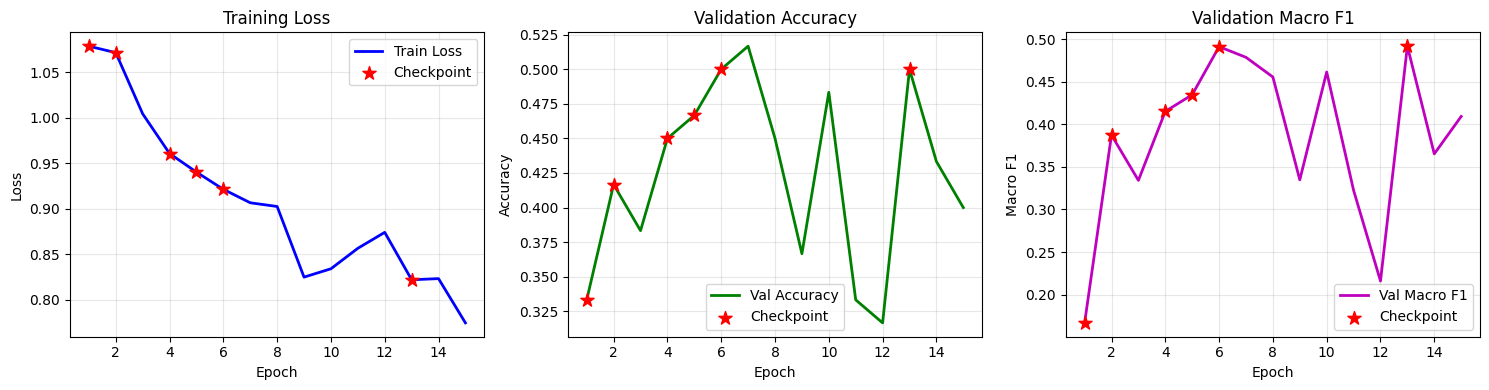


CHECKPOINT SUMMARY
  Checkpoint 1: Epoch 1, Macro F1 = 0.1667
  Checkpoint 2: Epoch 2, Macro F1 = 0.3875
  Checkpoint 3: Epoch 4, Macro F1 = 0.4153
  Checkpoint 4: Epoch 5, Macro F1 = 0.4349
  Checkpoint 5: Epoch 6, Macro F1 = 0.4915
  Checkpoint 6: Epoch 13, Macro F1 = 0.4920

Best checkpoint: Epoch 13, Macro F1 = 0.4920


In [34]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Training Loss
axes[0].plot(history["epoch"], history["train_loss"], 'b-', linewidth=2, label='Train Loss')
axes[0].scatter(history["checkpoint_epochs"], 
                [history["train_loss"][e-1] for e in history["checkpoint_epochs"]], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
axes[1].plot(history["epoch"], history["val_acc"], 'g-', linewidth=2, label='Val Accuracy')
axes[1].scatter(history["checkpoint_epochs"], 
                [history["val_acc"][e-1] for e in history["checkpoint_epochs"]], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Validation Macro F1
axes[2].plot(history["epoch"], history["val_f1"], 'm-', linewidth=2, label='Val Macro F1')
axes[2].scatter(history["checkpoint_epochs"], history["checkpoint_f1"], 
                c='red', s=100, zorder=5, marker='*', label='Checkpoint')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Macro F1')
axes[2].set_title('Validation Macro F1')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUT_DIR, "training_curves.png"), dpi=150, bbox_inches='tight')
plt.show()

# Print checkpoint summary
print("\n" + "="*50)
print("CHECKPOINT SUMMARY")
print("="*50)
for i, (ep, f1) in enumerate(zip(history["checkpoint_epochs"], history["checkpoint_f1"]), 1):
    print(f"  Checkpoint {i}: Epoch {ep}, Macro F1 = {f1:.4f}")
print(f"\nBest checkpoint: Epoch {history['checkpoint_epochs'][-1]}, Macro F1 = {best_f1:.4f}")
print("="*50)


Generating predictions for confusion matrix...
Confusion matrix saved to: /kaggle/working/confusion_matrix.png


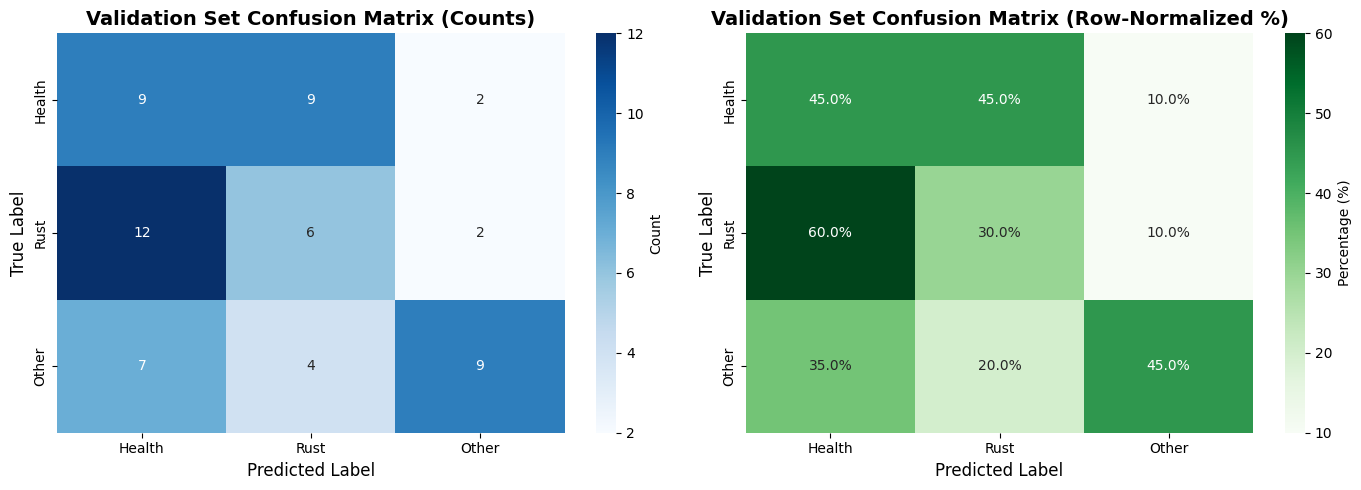


PER-CLASS METRICS
Class              Precision       Recall     F1-Score    Support
------------------------------------------------------------
Health                0.3214       0.4500       0.3750         20
Rust                  0.3158       0.3000       0.3077         20
Other                 0.6923       0.4500       0.5455         20
------------------------------------------------------------
Overall Accuracy: 0.4000 (24/60)


In [35]:
# ============================================================================
# Confusion Matrix Visualization
# ============================================================================
from sklearn.metrics import confusion_matrix as sklearn_cm
import seaborn as sns

@torch.no_grad()
def get_predictions_and_labels(model, loader, device):
    """Get all predictions and true labels from a dataloader"""
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch in loader:
        rgb  = batch["rgb"].to(device)
        ms   = batch["ms"].to(device)
        hs   = batch["hs"].to(device)
        mask = batch["mask"].to(device)
        y    = batch["y"].to(device)
        
        logits = model(rgb, ms, hs, mask)
        preds = logits.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix", save_path=None):
    """
    Plot a beautiful confusion matrix with counts and percentages
    """
    # Compute confusion matrix
    cm = sklearn_cm(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_title(f'{title} (Counts)', fontsize=14, fontweight='bold')
    
    # Plot 2: Percentages
    annot_pct = np.array([[f'{val:.1f}%' for val in row] for row in cm_normalized])
    sns.heatmap(cm_normalized, annot=annot_pct, fmt='', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_title(f'{title} (Row-Normalized %)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    # Print per-class metrics
    print("\n" + "="*60)
    print("PER-CLASS METRICS")
    print("="*60)
    print(f"{'Class':<15} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>10}")
    print("-"*60)
    
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        support = cm[i, :].sum()
        
        precision = tp / max(1, tp + fp)
        recall = tp / max(1, tp + fn)
        f1 = 2 * precision * recall / max(1e-8, precision + recall)
        
        print(f"{class_name:<15} {precision:>12.4f} {recall:>12.4f} {f1:>12.4f} {support:>10d}")
    
    # Overall metrics
    total_correct = np.diag(cm).sum()
    total_samples = cm.sum()
    accuracy = total_correct / total_samples
    
    print("-"*60)
    print(f"{'Overall Accuracy:':<15} {accuracy:.4f} ({total_correct}/{total_samples})")
    print("="*60)
    
    return cm

# Get predictions on validation set
print("Generating predictions for confusion matrix...")
y_pred_val, y_true_val = get_predictions_and_labels(model, dl_va, device)

# Plot confusion matrix
cm = plot_confusion_matrix(
    y_true_val, 
    y_pred_val, 
    class_names=LABELS,
    title="Validation Set Confusion Matrix",
    save_path=os.path.join(cfg.OUT_DIR, "confusion_matrix.png")
)

## Inference & summission

In [36]:
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"], strict=True)

pred_ids, pred_labels = predict(model, dl_te, device)


sub_ids = []
for _, r in val_df.iterrows():
    if isinstance(r.get("hs"), str) and r.get("hs"):
        sub_ids.append(os.path.basename(r["hs"]))
    elif isinstance(r.get("ms"), str) and r.get("ms"):
        sub_ids.append(os.path.basename(r["ms"]))
    else:
        sub_ids.append(os.path.basename(r["rgb"]))

In [37]:
sub = pd.DataFrame({"Id": sub_ids, "Category": pred_labels})
out_csv = os.path.join(cfg.OUT_DIR, "submission_only_HS_DC2Net.csv")
sub.to_csv(out_csv, index=False)

In [38]:
sub.head(3)

,Id,Category
0,val_000a83c1.tif,Other
1,val_00a704b1.tif,Other
2,val_01dde030.tif,Other
